# **Automatic Hyperparameter Optimization with MMoCHi**

**Authors:** Daniel Caron and Will Specht

**In this notebook, we will use MMoCHi's built-in hyperparameter optimization to improve the fit of the underlying random forests. Testing various hyperparameters is an important way to improve classification performance. This notebook will highlight some of the considerations taken during hyperparameter optimization and some keys to preventing overfitting.**
    
## What are hyperparameters?
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hyperparameters are parameters (e.g. arguments) passed to the machine learning function that alter the "learning" process. These parameters are very important because they can change how much a model relies on specific data (in our case, individual features or events), which change how closely that model can "fit" to the data. While we have set up MMoCHi with reasonable default hyperparameters that function well in a variety of our tests, the optimal hyperparameters will likely not be the defaults. Hyperparameter optimization is a cost-benefit analysis that will balance the cost (typically, the increased chance of over/underfitting or decreased computational efficiency) with the benefits (higher performance on a validation dataset). For example, consider a scenario where two cell subsets are distinguished by *only* one differentially expressed feature. A random forest with the default hyperparameters (chosen to prevent overfitting and to prevent reliance on individual features) may struggle to obtain a good fit. In this case, we may need to alter hyperparameters, increasing the risk of overfitting, in order to attain a good fit.

## How can you optimize hyperparameters?

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In order to find the best hyperparameters, we first need a metric for the random forest's performance. Typically, we rely on internally held-out data, which has been high-confidence thresholded, but not used for training the classifier. Then, we can train and evaluate classifiers at various hyperparameters until the model performs well. If you are unfamiliar with which types of hyperparameters to tune, we have built a tool to automatically optimize the most important hyperparameters. Unfortunately, it is not memory- or time-optimized for very large datasets. If computational performance is an issue, you may consider randomly subsampling the dataset to test hyperparameters. We test hyperparameters linearly (to reduce the number of permutations to test), but there are other methods for hyperparameter optimization, which you can read about [here](https://scikit-learn.org/stable/modules/grid_search.html).

**In this tutorial, we'll focus on guiding you through the process of applying automatic hyperparameter optimization and interpreting the results.**

## **Import Packages**

In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['legend.frameon'] = 'False'
plt.show() # so that the first plot will respect rcParams
import mmochi as mmc
import os
mmc.log_to_file('Hyperparameter_Optimization')

# Make the directory if not being run in the docs folder
if not os.path.isdir('data'):
    os.mkdir('data')

In [2]:
# Set deault locations in your anndata for MMoCHi to use for protein and batch labels
mmc.DATA_KEY = 'landmark_protein'
mmc.BATCH_KEY = 'batch'

In [3]:
# Load in your anndata
assert os.path.isfile('data/classified_events.h5ad'), 'Objects not found. Run the Integrated Clasification tutorial to generate them!'
adata = anndata.read_h5ad('data/classified_events.h5ad') 

### Initialize your hierarchy with hyperparameter optimization turned "on"

Here, we want to optimize hyperparameters at all classification notes in the hierarchy. You can also optimize hyperparameters at a single level by removing the "default_" from each of these parameter names, and passing it in the `mmc.Hierarchy.add_classification()` method!

Hyperparameter optimization can be enabled by just setting `default_optimize_hyperparameters=True`. Here, we are just showing the other relevant parameters as well.

In [4]:
h = mmc.Hierarchy(default_min_events=15, default_class_weight = 'balanced',
                  default_optimize_hyperparameters=True, 
                  default_hyperparameter_order=['n_estimators', 'max_depth', 'max_features', 'bootstrap'],
                  default_hyperparameters={'n_estimators': [50, 100, 200, 400, 800, 1200], 
                                           'max_depth': [None, 10, 25], 
                                           'max_features': ['log2', 'sqrt', 0.05, 0.1], 
                                           'bootstrap': [True, False]},
                  default_hyperparameter_min_improvement = {'n_estimators': 0.004, 'max_features': 0.004},
                  default_hyperparameter_optimization_cap = 0.98)
        

<div class="alert alert-warning">
    
**Note!** 
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Optimization is performed using a pre-set list of hyperparameters and values, which can be altered using `hyperparameters`. The hyperparameters are optimized using a linear search (not a grid search) to save computational time. The order of this optimization is defined by `hyperparameter_order`. Optimization of a random forest is set internally to stop if subset balanced accuracy exceeds 98% or if there is less than a 0.4% improvement (e.g. with an increase in n_estimators). These defaults were included to save classification and optimization time and prevent overfitting, but can be adjusted using the `hyperparameter_optimization_cap` and `hyperparameter_min_improvement` respectively.

</div>

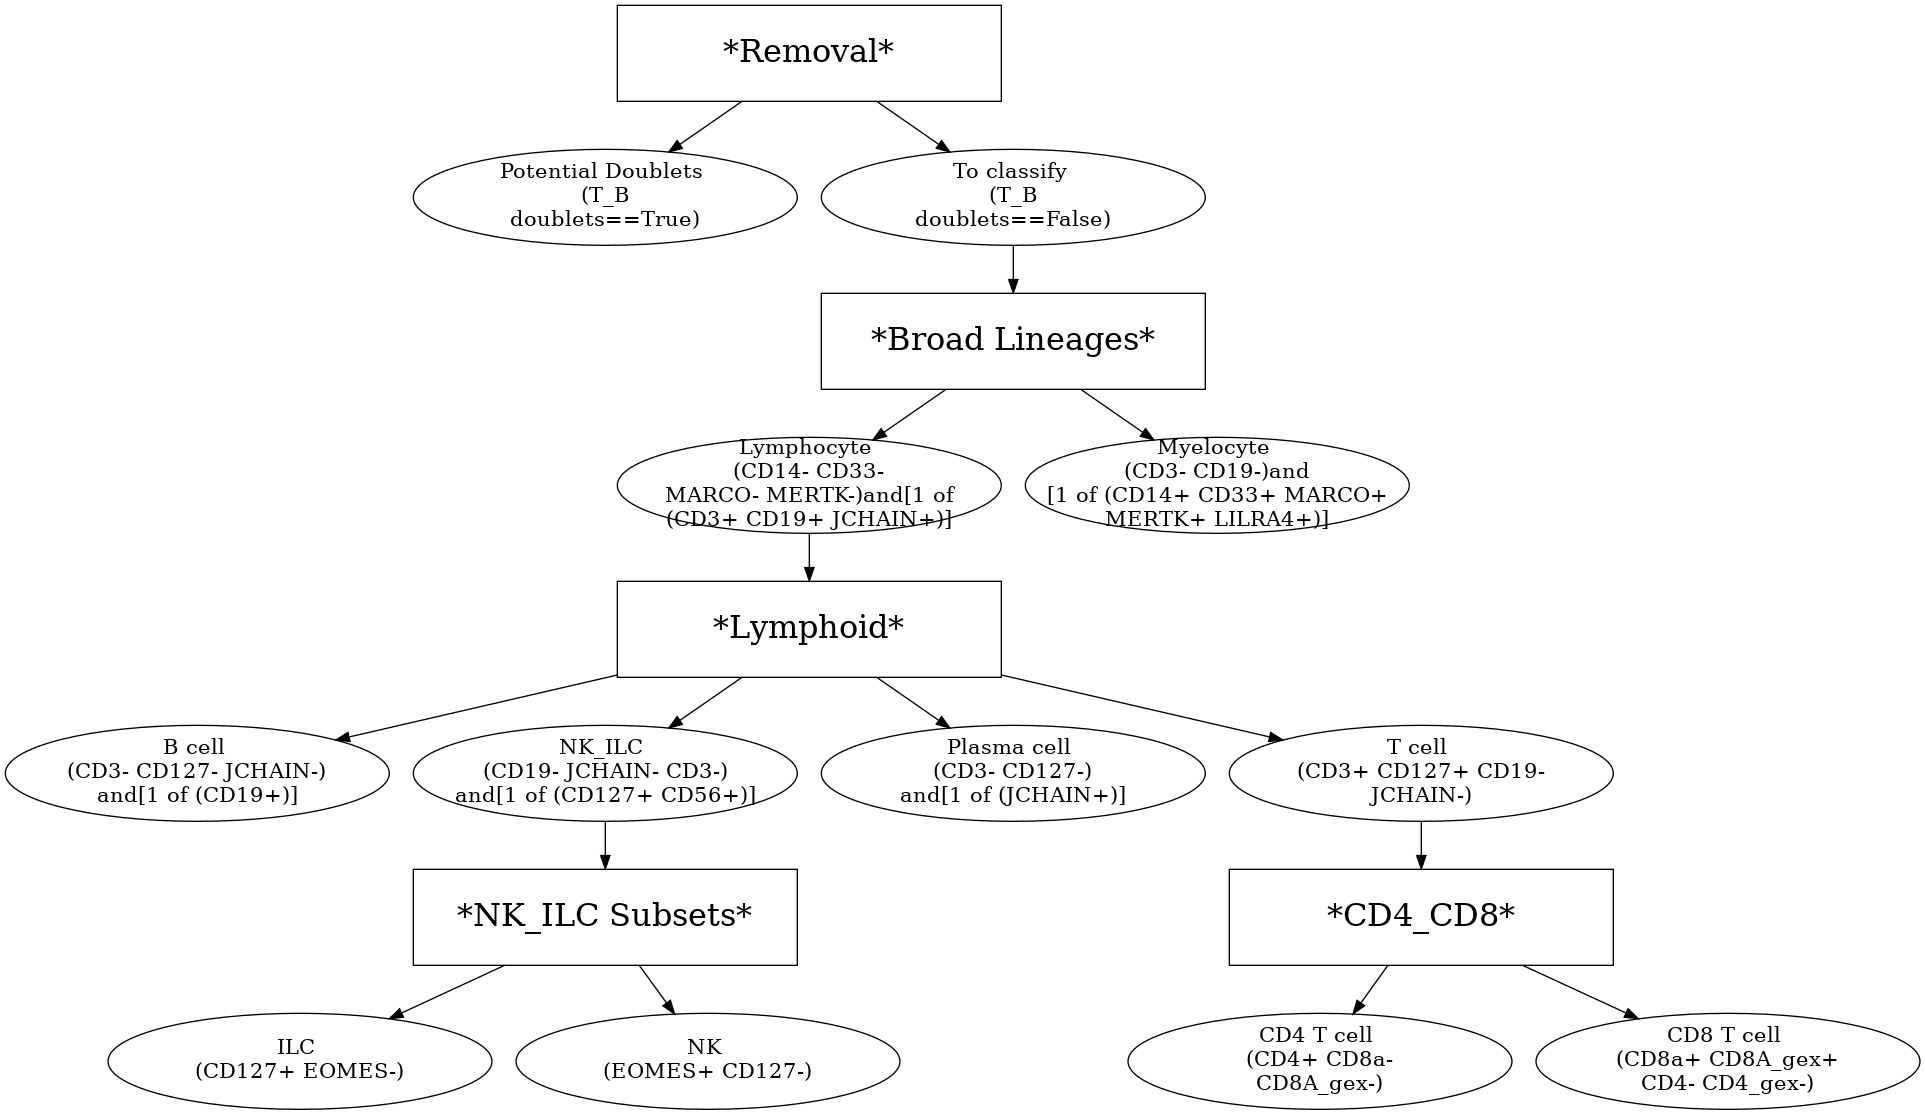

In [5]:
h.add_classification('Removal', 'All', ['T_B doublets'], is_cutoff=True) 
h.add_subset('Potential Doublets', 'Removal', ['True'])
h.add_subset('To classify', 'Removal', ['False'])
h.add_classification('Broad Lineages', 'To classify', ['CD14','CD33','MARCO','MERTK','CD3','CD19','JCHAIN','LILRA4']) 
h.add_subset('Lymphocyte', 'Broad Lineages', dict(neg=['CD14','CD33','MARCO','MERTK'], any_of=['CD3','CD19','JCHAIN'], n=1))
h.add_subset('Myelocyte', 'Broad Lineages', dict(any_of=['CD14','CD33','MARCO','MERTK','LILRA4'], neg=['CD3','CD19'], n=1))
h.add_classification('Lymphoid', 'Lymphocyte', ['CD3','CD19','CD56','CD127','JCHAIN'])           
h.add_subset('T cell', 'Lymphoid', dict(pos=['CD3','CD127'], neg=['CD19','JCHAIN']))
h.add_subset('B cell', 'Lymphoid', dict(any_of=['CD19'], neg=['CD3','CD127','JCHAIN']))
h.add_subset('Plasma cell', 'Lymphoid', dict(any_of=['JCHAIN'], neg=['CD3','CD127']))
h.add_subset('NK_ILC', 'Lymphoid', dict(neg=['CD19','JCHAIN','CD3'], any_of=['CD127','CD56']))
h.add_classification('NK_ILC Subsets', 'NK_ILC', ['CD127','EOMES'])
h.add_subset('NK', 'NK_ILC Subsets', dict(neg=['CD127',], pos=['EOMES',]))
h.add_subset('ILC', 'NK_ILC Subsets', dict(pos=['CD127',], neg=['EOMES',]))
h.add_classification('CD4_CD8', 'T cell', ['CD4','CD8a','CD4_gex','CD8A_gex'])
h.add_subset('CD4 T cell', 'CD4_CD8', dict(pos=['CD4',], neg=['CD8a','CD8A_gex']))
h.add_subset('CD8 T cell', 'CD4_CD8', dict(neg=['CD4','CD4_gex'], pos=['CD8a','CD8A_gex']))
h.display(True)

In [6]:
h.reset_thresholds()
h.load_thresholds('data/integrated_thresholds.csv')

Loaded thresholds.


## **Time to run the classifier**
Optimization is as simple as running the classifier with optimization set to true in the hierarchy. Keep an eye out for optimization print statements to better understand which layers are well fit.

In [7]:
adata, hierarchy = mmc.classify(adata, h.copy(), 'lin', 'landmark_protein', retrain=True, weight_integration=True)


Setting up...


No provided modality name, defaulting to gex for all of .X


Using .X and landmark_protein


Removing 18757 features lacking expression in a minimum of 25 events...
Resorting to enforce sorted order of features by name


Set up complete.
Using 14795 features


Running with batch batch
Using weights of: [np.float64(0.4001677852348993), np.float64(0.5998322147651006)] for random forest n_estimators


Data subsetted on All in All
Running high-confidence populations for Removal...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Performing cutoff for Removal...
Merging data into adata.obsm['lin']
Predicted:
Removal_class
To classify           13035
Potential Doublets       77
Name: count, dtype: int64
Data subsetted on To classify in Removal
Running high-confidence populations for Broad Lineages...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Broad Lineages...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt'}
Manually made a balanced class_weight: {'Lymphocyte': np.float64(1.170774425137139), 'Myelocyte': np.float64(1.922890096843606)}


Initializing classifier for Broad Lineages...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


3623 real cells in training set...


Resampling...


/home/ubuntu/_Codebases/MMoCHi/mmochi/classifier.py:1077: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution = .5,n_iterations=1)
Found: 56 noise and 7 in danger of 3623 events.


Training with 5064 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.4s finished
Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


4596 real cells in training set...


Resampling...


Found: 89 noise and 0 in danger of 4596 events.


Training with 6808 events after oversample resampling...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.3s finished


Optimizing hyperparameters for Broad Lineages...


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s


Using optimization cap of 0.98 and min_improvement of 0.004 for n_estimators
Optimization cap reached for level Broad Lineages, skipping param n_estimators and beyond
Best hyperparameters selected for level Broad Lineages as {'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt'} with an balanced accuracy of 0.9822096040758994


[Parallel(n_jobs=20)]: Done 101 out of 101 | elapsed:    0.9s finished


Merging data into adata.obsm['lin']
Running calibration on random forest


Calibrating with method isotonic
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s


Predicting for Broad Lineages...


[Parallel(n_jobs=20)]: Done 101 out of 101 | elapsed:    0.6s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.7s


Merging data into adata.obsm['lin']
Predicted:
Broad Lineages_class
Lymphocyte    8868
Myelocyte     4167
Name: count, dtype: int64


[Parallel(n_jobs=20)]: Done 101 out of 101 | elapsed:    2.0s finished


Data subsetted on Lymphocyte in Broad Lineages
Running high-confidence populations for Lymphoid...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for Lymphoid...


Checking subsets for minimum events...
Spiking in 15 of Plasma cell in 5k_pbmc_protein_v3 to reach 15 events
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': False, 'max_features': 'sqrt'}
Manually made a balanced class_weight: {'B cell': np.float64(3.214771816903625), 'NK_ILC': np.float64(2.685466369602569), 'Plasma cell': np.float64(14.39742040386799), 'T cell': np.float64(1.1472659492028388)}


Initializing classifier for Lymphoid...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2467 real cells in training set...


Resampling...


Found: 8 noise and 19 in danger of 2467 events.


Training with 8228 events after oversample resampling...


Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


3384 real cells in training set...


Resampling...


Found: 10 noise and 6 in danger of 3384 events.


Training with 9676 events after oversample resampling...
Optimizing hyperparameters for Lymphoid...
Using optimization cap of 0.98 and min_improvement of 0.004 for n_estimators
Optimization cap reached for level Lymphoid, skipping param n_estimators and beyond
Best hyperparameters selected for level Lymphoid as {'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt'} with an balanced accuracy of 0.9941860465116279
Merging data into adata.obsm['lin']
Running calibration on random forest


Calibrating with method isotonic


Predicting for Lymphoid...
Merging data into adata.obsm['lin']
Predicted:
Lymphoid_class
T cell         6700
NK_ILC         1236
B cell          864
Plasma cell      68
Name: count, dtype: int64
Data subsetted on NK_ILC in Lymphoid
Running high-confidence populations for NK_ILC Subsets...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for NK_ILC Subsets...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': False, 'max_features': 'sqrt'}
Manually made a balanced class_weight: {'ILC': np.float64(2.4238399287081647), 'NK': np.float64(1.0977833142875715)}


Initializing classifier for NK_ILC Subsets...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


75 real cells in training set...


Resampling...


Found: 7 noise and 5 in danger of 75 events.


Training with 112 events after oversample resampling...


Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


156 real cells in training set...


Resampling...


Found: 1 noise and 5 in danger of 156 events.


Training with 286 events after oversample resampling...


Optimize holdout contains too few events in some classes, which may make hyperparameter optimization or calibration unstable.
NK_ILC Subsets_hc
NK     25
ILC     1
Name: count, dtype: int64


Optimizing hyperparameters for NK_ILC Subsets...
Using optimization cap of 0.98 and min_improvement of 0.004 for n_estimators
Score for n_estimators: 50 = 1.0
Score for n_estimators: 100 = 0.5
Best parameter for n_estimators was 50 with an accuracy score of 1.0
Using optimization cap of 0.98 and min_improvement of -1.0 for max_depth
Optimization cap reached for level NK_ILC Subsets, skipping param max_depth and beyond
Best hyperparameters selected for level NK_ILC Subsets as {'max_depth': 20, 'n_estimators': 50, 'n_jobs': -1, 'bootstrap': True, 'verbose': True, 'max_features': 'sqrt'} with an balanced accuracy of 1.0
Merging data into adata.obsm['lin']
Running calibration on random forest


Calibration will not include separate _opt_holdout
Calibrating with method isotonic


Predicting for NK_ILC Subsets...
Merging data into adata.obsm['lin']
Predicted:
NK_ILC Subsets_class
NK     955
ILC    281
Name: count, dtype: int64
Data subsetted on T cell in Lymphoid
Running high-confidence populations for CD4_CD8...


Running high-confidence thresholds in 5k_pbmc_protein_v3
Running high-confidence thresholds in pbmc_10k_protein_v3


Preparing training data for CD4_CD8...


Checking subsets for minimum events...
{'max_depth': 20, 'n_estimators': 100, 'n_jobs': -1, 'bootstrap': True, 'verbose': False, 'max_features': 'sqrt'}
Manually made a balanced class_weight: {'CD4 T cell': np.float64(1.094554335897675), 'CD8 T cell': np.float64(2.4595224201726453)}


Initializing classifier for CD4_CD8...


Training 41 new estimators using 5k_pbmc_protein_v3...


Choosing training data...


2018 real cells in training set...


Resampling...


Found: 22 noise and 38 in danger of 2018 events.


Training with 3740 events after oversample resampling...


Training 60 new estimators using pbmc_10k_protein_v3...


Choosing training data...


2499 real cells in training set...


Resampling...


Found: 20 noise and 12 in danger of 2499 events.


Training with 3910 events after oversample resampling...
Optimizing hyperparameters for CD4_CD8...
Using optimization cap of 0.98 and min_improvement of 0.004 for n_estimators
Score for n_estimators: 50 = 0.8737864077669903
Score for n_estimators: 100 = 0.9077669902912622
Score for n_estimators: 200 = 0.9077669902912622
Best parameter for n_estimators was 100 with an accuracy score of 0.9077669902912622
Using optimization cap of 0.98 and min_improvement of -1.0 for max_depth
Score for max_depth: None = 0.883495145631068
Score for max_depth: 10 = 0.9649842207883575
Score for max_depth: 25 = 0.8737864077669903
Best parameter for max_depth was 10 with an accuracy score of 0.9649842207883575
Using optimization cap of 0.98 and min_improvement of 0.004 for max_features
Score for max_features: log2 = 0.8029608635349452
Score for max_features: sqrt = 0.936571589378681
Score for max_features: 0.05 = 1.0
Score for max_features: 0.1 = 1.0
Best parameter for max_features was 0.05 with an accuracy 

Calibrating with method isotonic


Predicting for CD4_CD8...
Merging data into adata.obsm['lin']
Predicted:
CD4_CD8_class
CD4 T cell    5094
CD8 T cell    1606
Name: count, dtype: int64


Converting columns in adata.obsm["lin"] to savable dtypes...


We can summarize the selected hyperparameters using the following function. Note, this pulls the hyperparameters directly from the trained RandomForest classifier, where n_estimators will usually round up by 1 or 2.

In [8]:
hierarchy.get_optimal_clf_kwargs()

,n_estimators,max_depth,max_features,bootstrap
Broad Lineages,101,20,sqrt,True
Lymphoid,101,20,sqrt,True
NK_ILC Subsets,51,20,sqrt,True
CD4_CD8,101,10,0.05,True


## Interpreting your selected hyperparameters

To better understand the selected hyperparameters or to manually tune hyperparameters yourself, it is useful to introduce the way these parameters often connect to the biology of your dataset. 

- `n_estimators` — Indicates the number of trees in the forest required to effectively classify your dataset. In general, more trees will always lead to better performance and will not lead to overfitting, but can come at a computational cost.

- `max_depth` — A greater max_depth of each tree in the forest is correlated with requiring many features to effectively separate subsets. Higher numbers of max_depth (or "None") is therefore associated with more complex classifications without as many clearly defining features. This could be because a subset is heterogenous, or suggest subsets are highly similar. Greater max_depths can increase risk of overfitting, and will also come at a slight computational cost. 

- `max_features` – The value (or fraction) of max_features indicates the amount of features that a tree in the random forest has access to for each decision node. This is directly linked to how many features the overall random forest will be forced to rely on. Therefore, classification tasks with only a small number of key differentiating features (such as CD4 vs CD8 T cells), may require larger fractions in order to increase the chance that a tree can "see" an important feature. However, using a high number of max_features on classification layers may lead to overfitting.

- `bootstrap` – Whether the set of training events is bootstrapped between each tree. Typically this is enabled as it prevents overfitting to individual events.

There are also many other hyperparameters which can be tuned. Read more [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)!


In [9]:
adata = mmc.terminal_names(adata)

## **Evaluate your (potentially) improved performance**

First, let's check whether each layer is able to fit your data well. 

These confusion matrices measure how well fit your classier is at each level. If they are still poorly fit, consider redesigning your hierarchy or improving your training data selection.

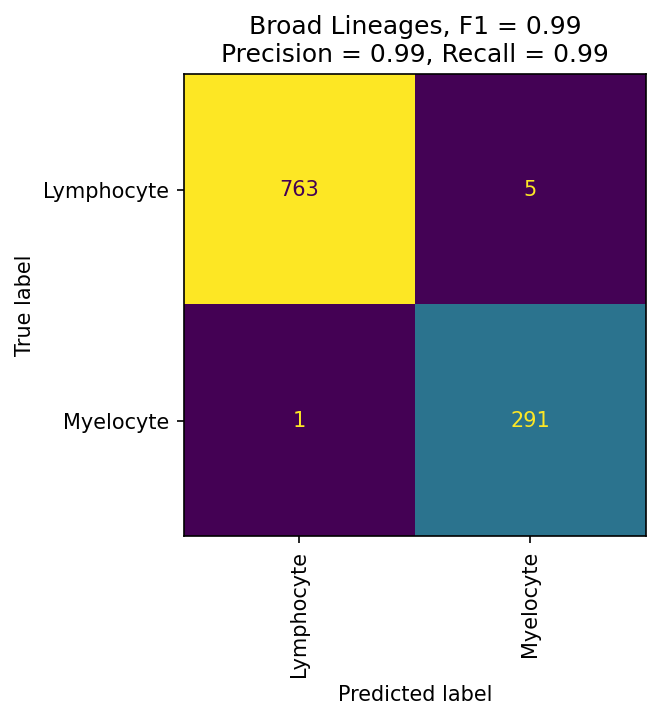

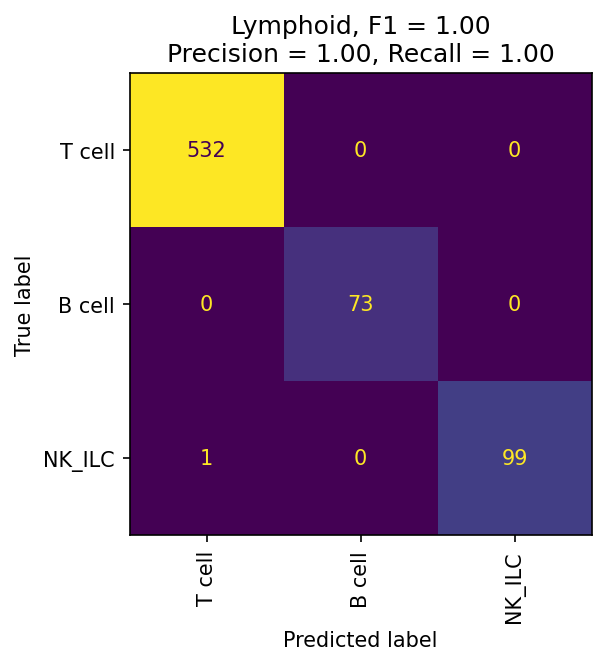

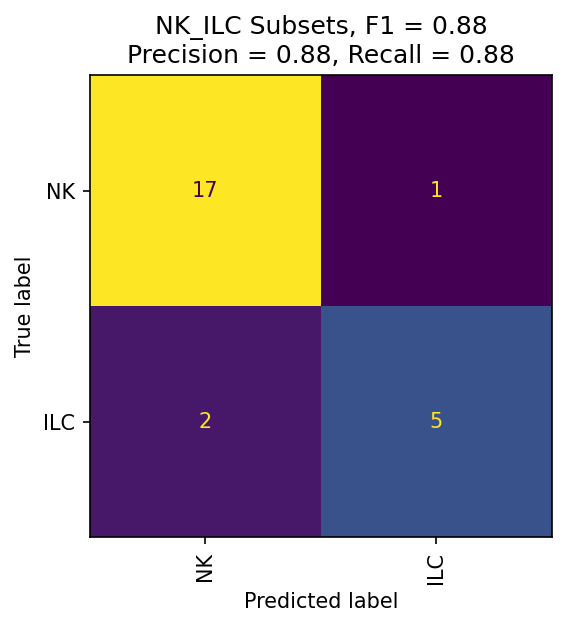

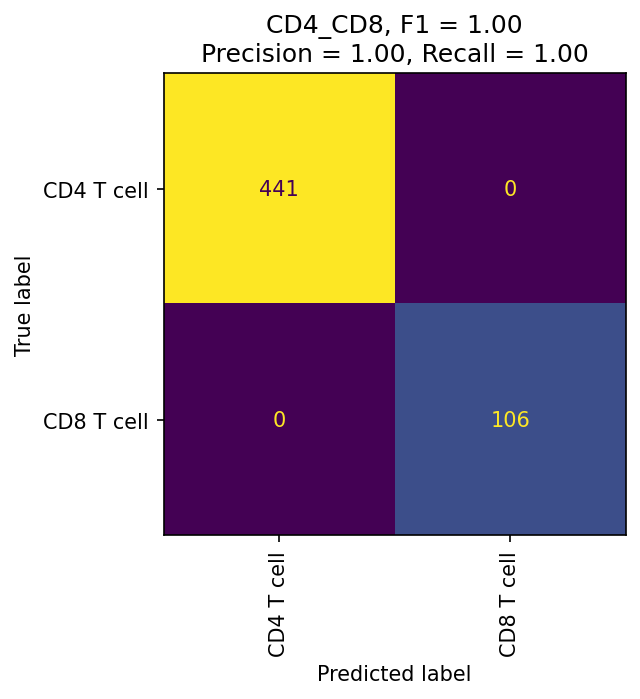

In [10]:
mmc.plot_confusion(adata, 'All', hierarchy, show=True, holdout_only=True, save='data/Confusion_plots_optimized.pdf')

#### Do classifications align with expected marker expression?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The most important evaluation of classification performance is whether classified populations express expected marker genes and proteins. The MMoCHi classifications should reflect the known markers that were used in high-confidence thresholding, as well as other known cell type markers. We can inspect the classifications using the UMAP and markers from before:

In [11]:
protein_adata = anndata.AnnData(adata.obsm['landmark_protein'], adata.obs.copy())
protein_adata.obsm['X_umap'] = adata.obsm['X_umap'].copy()

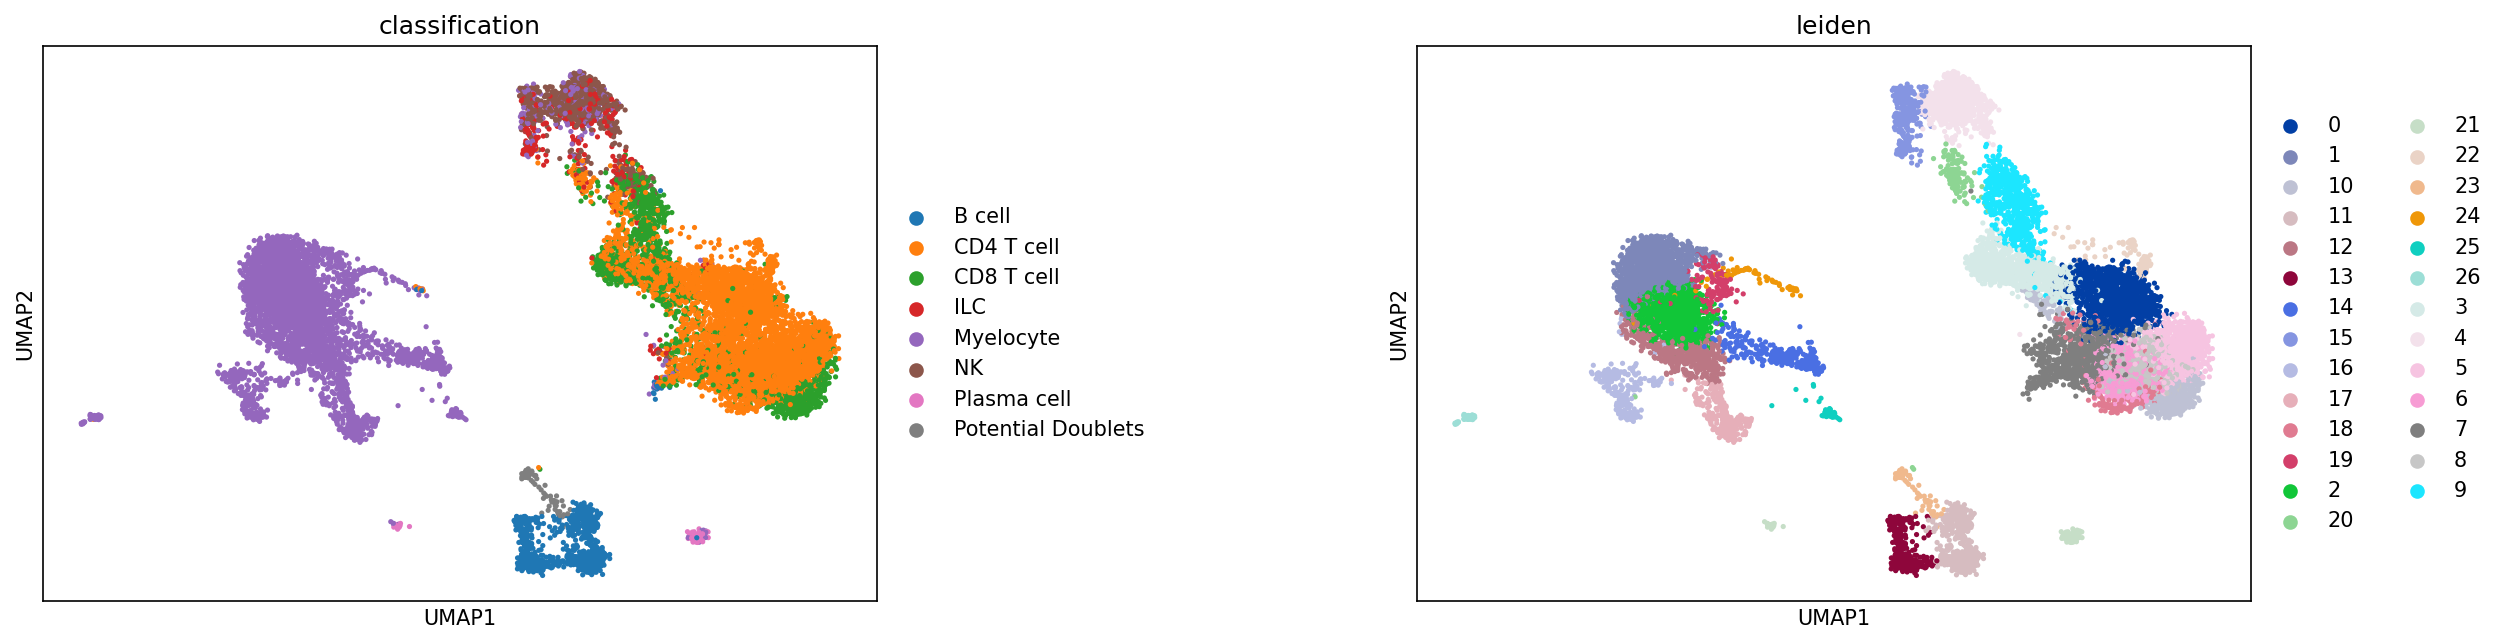

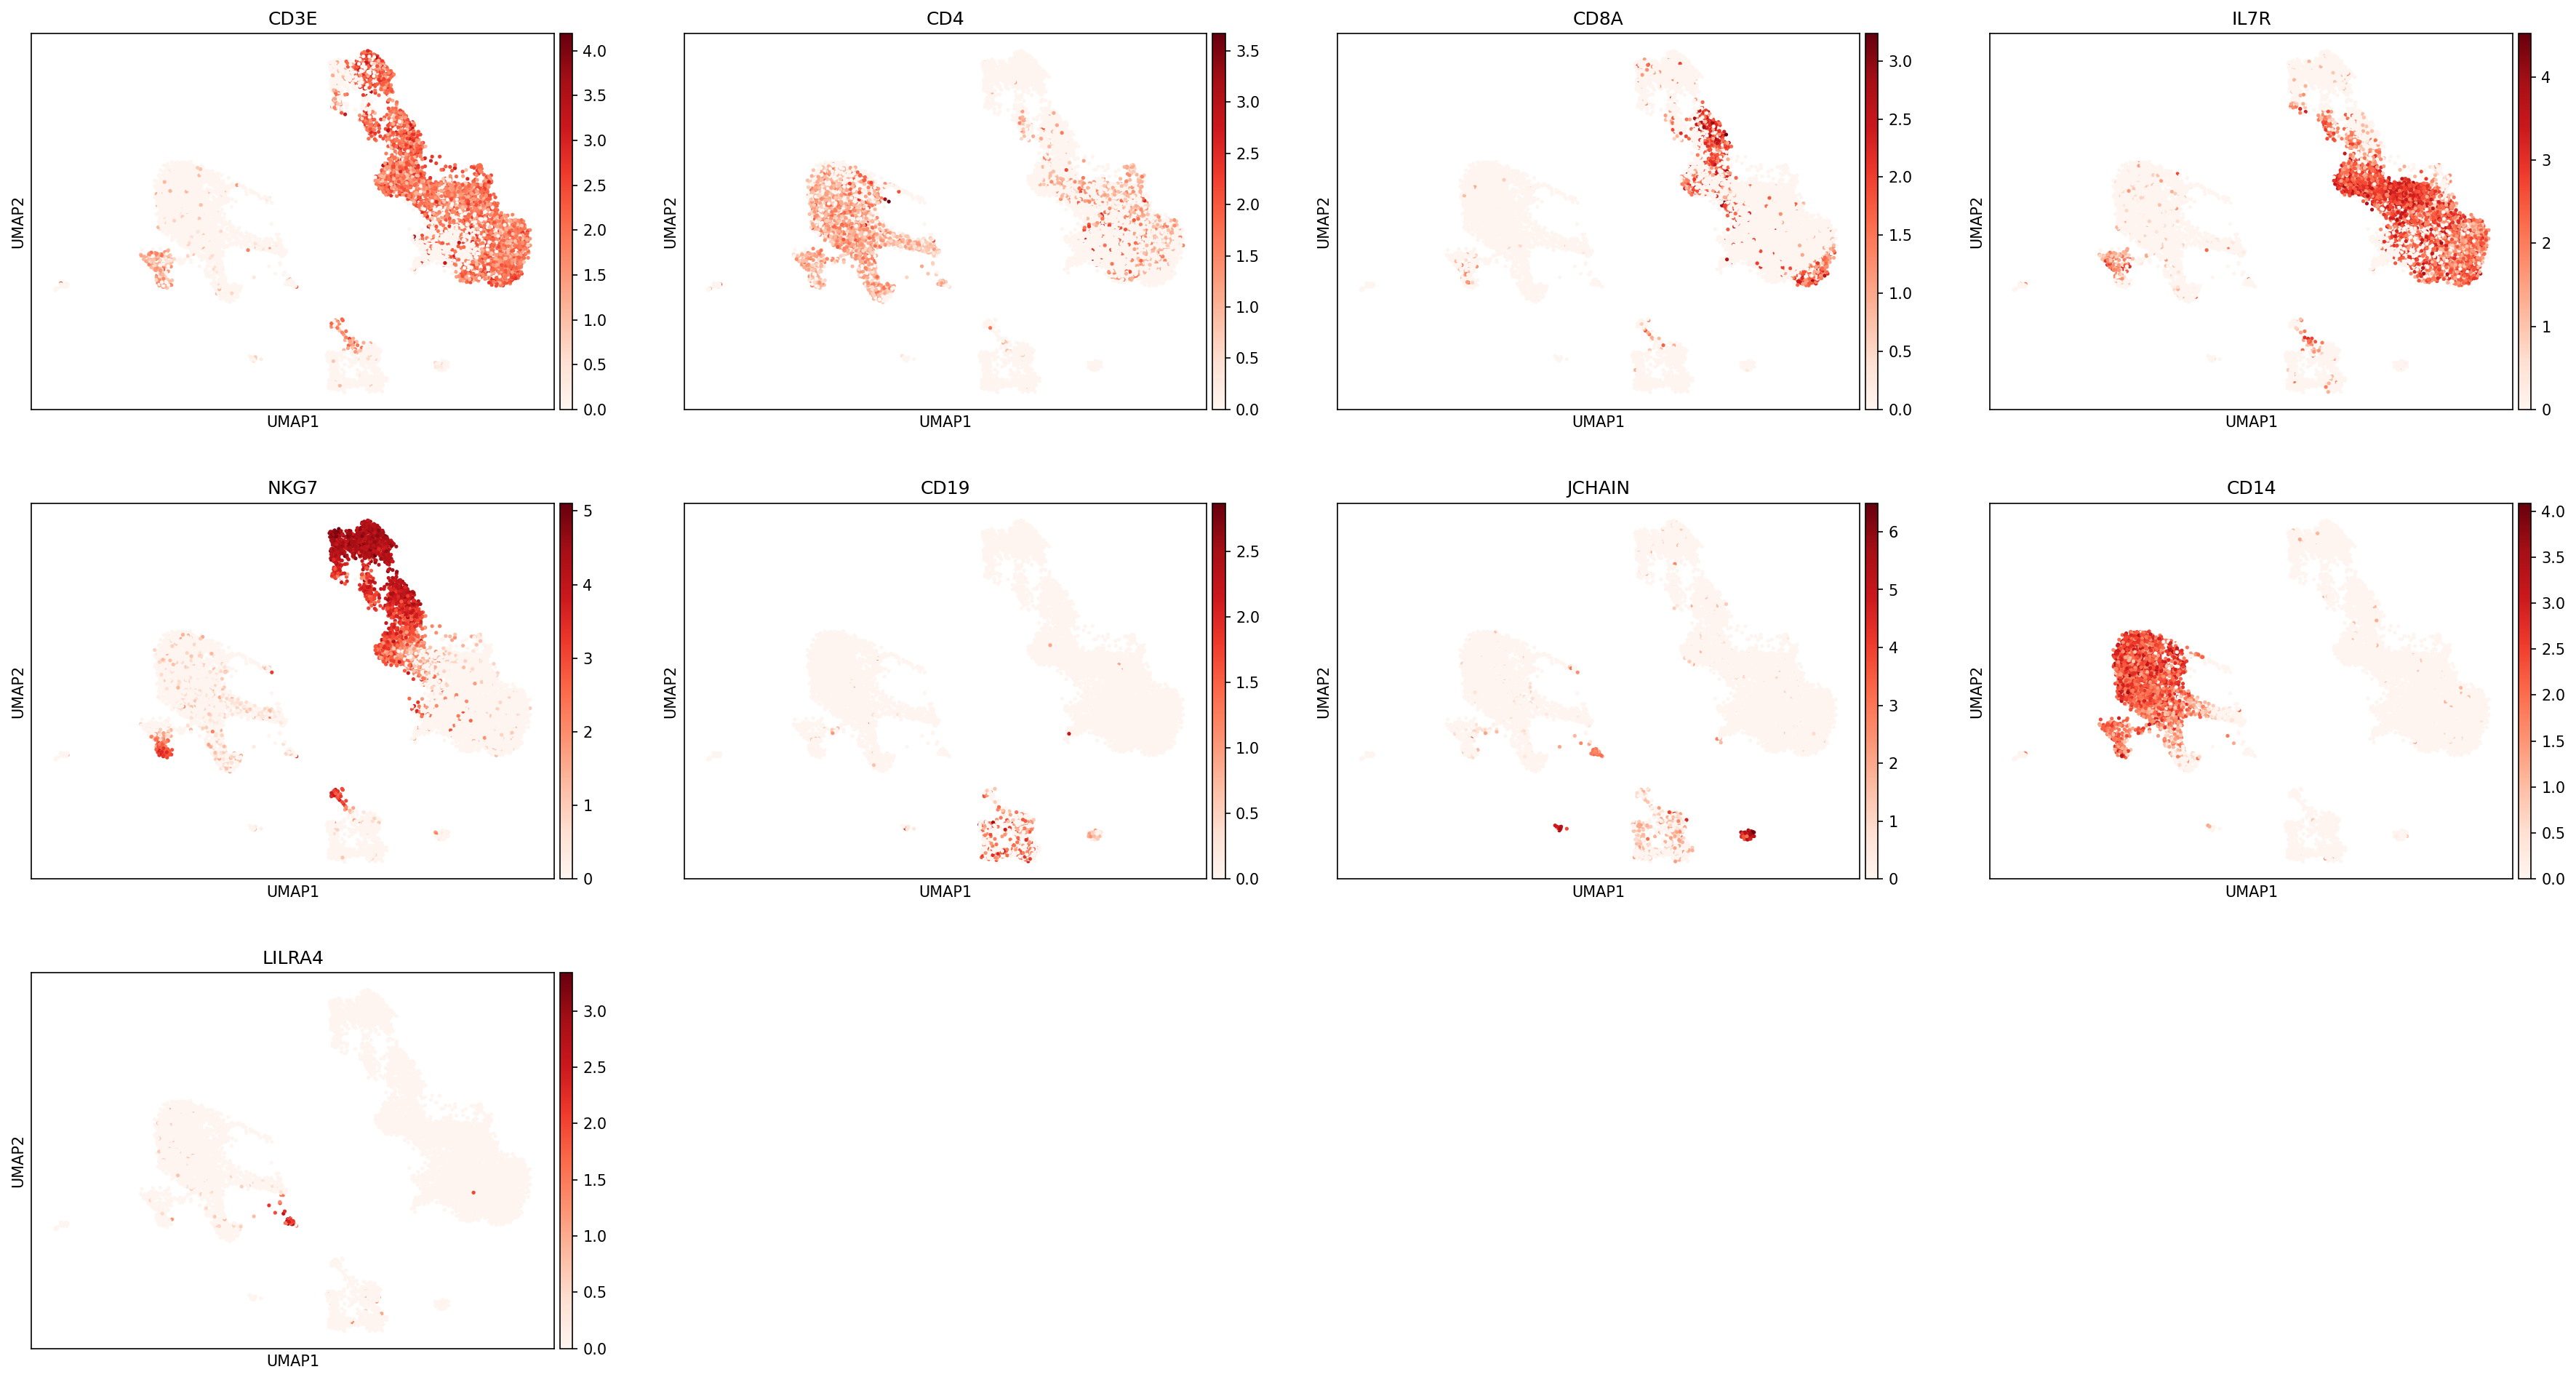

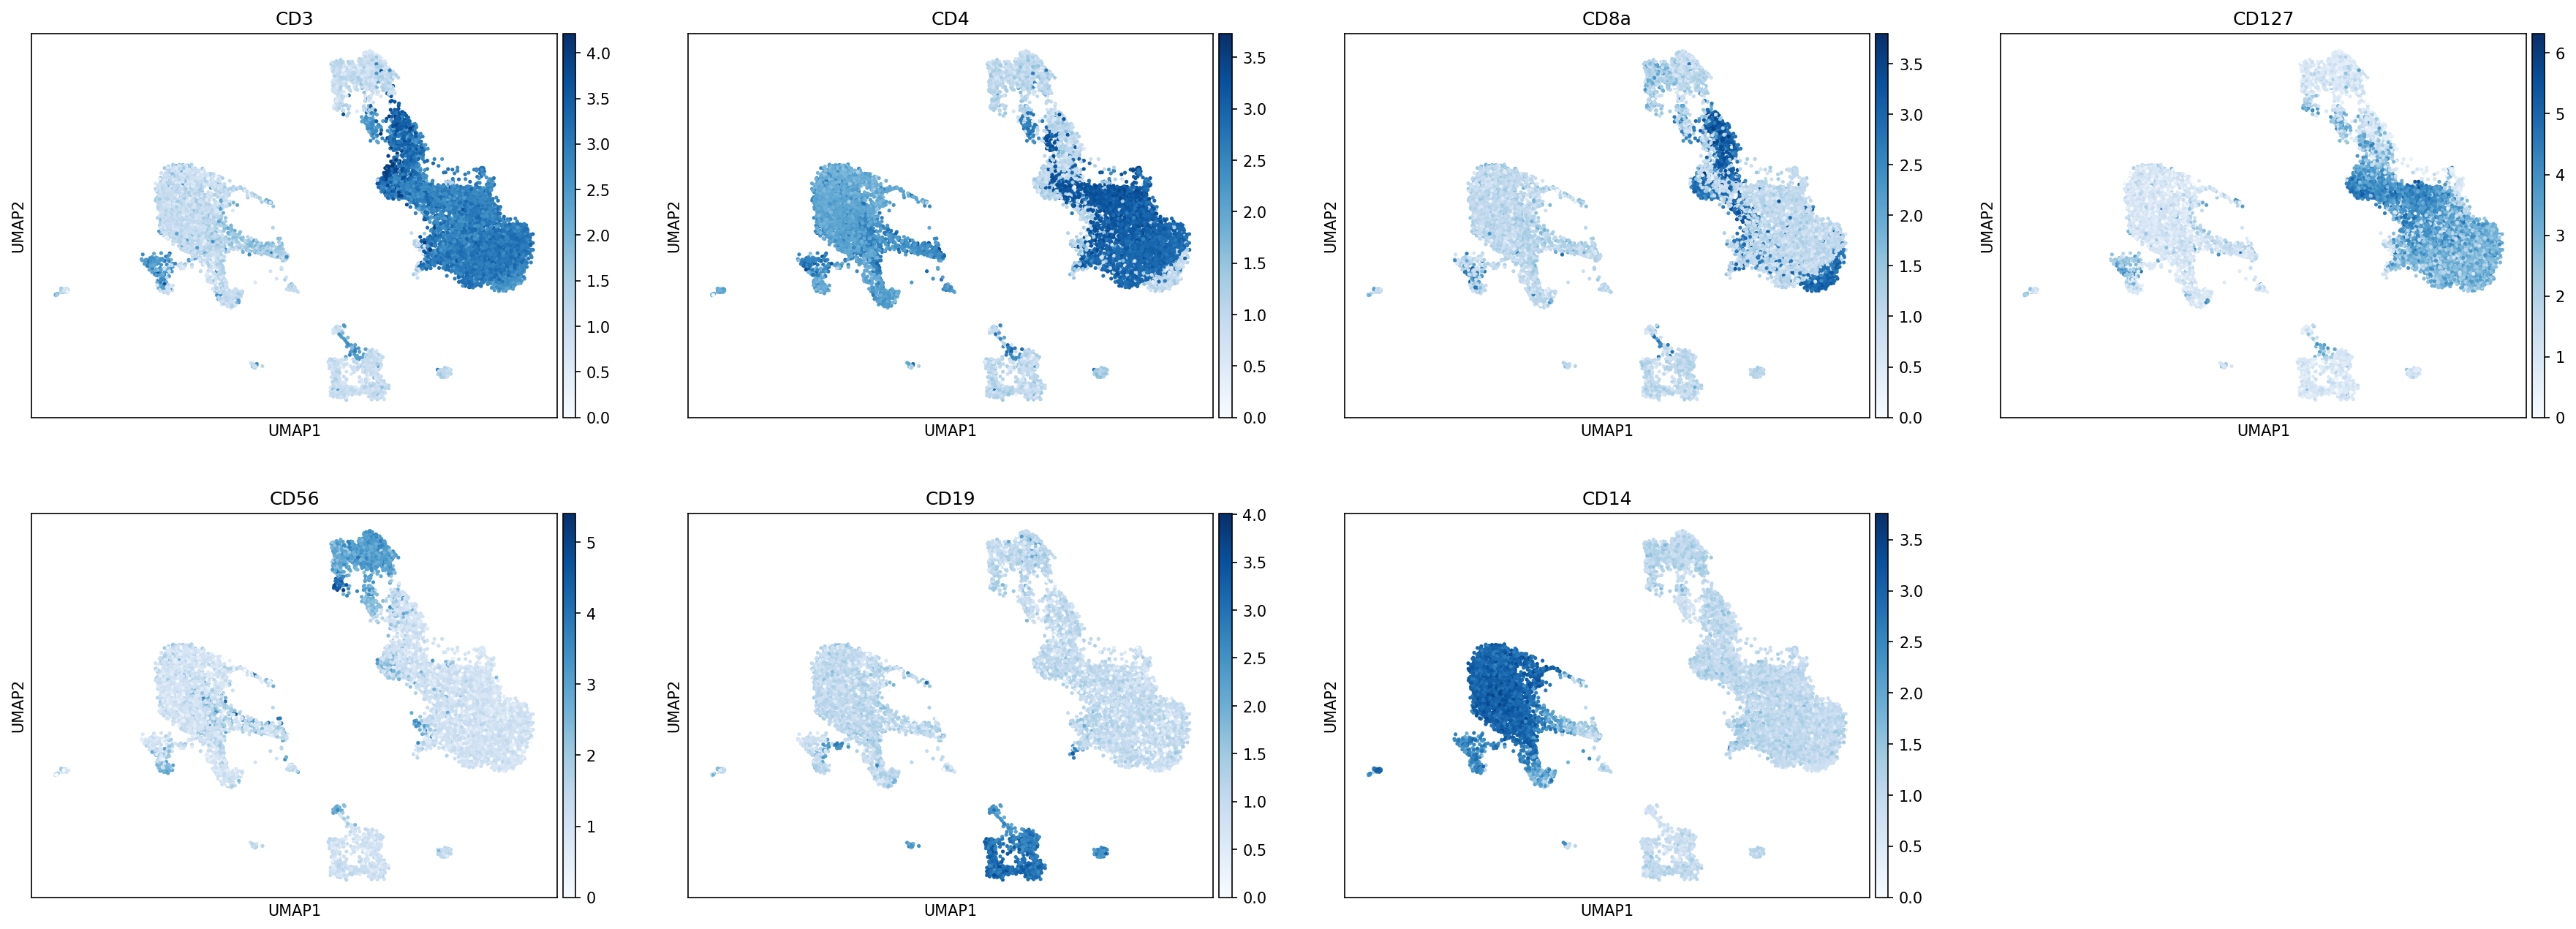

In [12]:
sc.pl.umap(adata, color=['classification','leiden'], s=25, sort_order=False, wspace=.5)
sc.pl.umap(adata, color=['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14','LILRA4'], s=25, sort_order=False, cmap='Reds')
sc.pl.umap(protein_adata, color=['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], s=25, sort_order=False, cmap='Blues')

We can also look at marker expression using dotplots for GEX and violin plots for ADTs. This is great for populations that segregate poorly on the UMAP and can help to identify outliers.

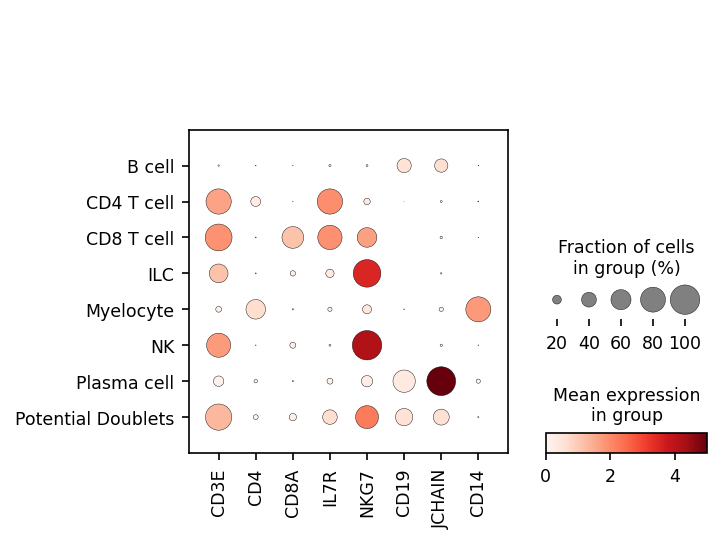

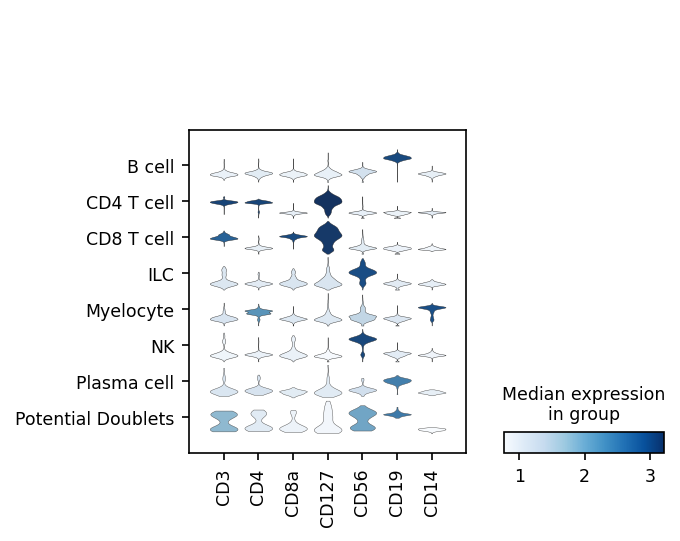

In [13]:
sc.pl.dotplot(adata, ['CD3E','CD4','CD8A','IL7R','NKG7','CD19','JCHAIN','CD14'], 'classification')
protein_adata.obs['classification'] = adata.obs.classification
sc.pl.stacked_violin(protein_adata, ['CD3','CD4','CD8a','CD127','CD56','CD19','CD14'], 'classification')

<div class="alert alert-info">

**Further Troubleshooting**
    
If classified subsets still do not align to known markers, you should check these other troubleshooting techniques:
1. High-confidence thresholding — Did you capture a relevant selection? See the [High-Confidence Thresholding tutorial](./High_Confidence_Thresholding.ipynb) for more details.
2. Training data cleanup and resampling — Are the high-confidence events well represented in training data? Alternative methods for cleanup and resampling are described in `mmc.classifier._balance_training_classes`. Note, alternative resampling methods are experimental.
3. Class imbalance — High imbalance between event numbers across subsets in one classification level may lead to poor classification performance, which is often revealed by sigmoidal-calibration plots. Consider altering classifier kwargs or redesigning the hierarchy to reduce/isolate this imbalance (imbalances tend to classify better in binary classification levels).
4. Learned representation — Are random forests learning the correct representation of the cell types? This question is explored in the [Exploring Feature Importances tutorial](./Exploring_Feature_Importances.ipynb), and these issues are best resolved by redesigning the hierarchy or changing feature inputs to isolate confounding variation. 
</div>

<div class="alert alert-success">

**Congratulations!** 
    
You've complete the automated hyperparameter optimization tutorial with MMoCHi!
</div>